# Samsung Deflicker

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Introduction

The
[Convolutional LSTM](https://papers.nips.cc/paper/2015/file/07563a3fe3bbe7e3ba84431ad9d055af-Paper.pdf)
architectures bring together time series processing and computer vision by
introducing a convolutional recurrent cell in a LSTM layer. In this example, we will explore the
Convolutional LSTM model in an application to next-frame prediction, the process
of predicting what video frames come next given a series of past frames.

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

## Dataset Construction

For this example, we will be using the
[Moving MNIST](http://www.cs.toronto.edu/~nitish/unsupervised_video/)
dataset.

We will download the dataset and then construct and
preprocess training and validation sets.

For next-frame prediction, our model will be using a previous frame,
which we'll call `f_n`, to predict a new frame, called `f_(n + 1)`.
To allow the model to create these predictions, we'll need to process
the data such that we have "shifted" inputs and outputs, where the
input data is frame `x_n`, being used to predict frame `y_(n + 1)`.

In [ ]:
# # Download and load the dataset.
# fpath = keras.utils.get_file(
#     "moving_mnist.npy",
#     "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
# )

fpath_x = '/content/drive/MyDrive/Deflicker/input2.npy'
fpath_y = '/content/drive/MyDrive/Deflicker/output2.npy'

no_frames = 5
no_videos = 1

import numpy as np

# Load the entire arrays from the files
data_x = np.load(fpath_x)
data_y = np.load(fpath_y)

# Get the total number of frames in the arrays
total_frames = data_x.shape[0]

# Choose five unique random frame indices
random_frame_indices = np.random.choice(total_frames, size=5, replace=False)

# Use the randomly selected indices to get the corresponding frames
dataset_x = data_x[random_frame_indices]
dataset_y = data_y[random_frame_indices]


# # Swap the axes representing the number of frames and number of data samples.
# dataset = np.swapaxes(dataset, 0, 1)
# # We'll pick out 1000 of the 10000 total examples and use those.
# dataset = dataset[:1000, ...]
# # Add a channel dimension since the images are grayscale.
# dataset = np.expand_dims(dataset, axis=-1)

# # Split into train and validation sets using indexing to optimize memory.
# indexes = np.arange(dataset.shape[0])
# np.random.shuffle(indexes)
# train_index = indexes[: int(0.9 * dataset.shape[0])]
# val_index = indexes[int(0.9 * dataset.shape[0]) :]
# train_dataset = dataset[train_index]
# val_dataset = dataset[val_index]

# # Normalize the data to the 0-1 range.
# # We'll define a helper function to shift the frames, where
# # `x` is frames 0 to n - 1, and `y` is frames 1 to n.
# def create_shifted_frames(data):
#     x = data[:, 0 : data.shape[1] - 1, :, :]
#     y = data[:, 1 : data.shape[1], :, :]
#     return x, y


# # Apply the processing function to the datasets.
# x_train, y_train = create_shifted_frames(train_dataset)
# x_val, y_val = create_shifted_frames(val_dataset)

x_train, y_train = np.array(dataset_x), np.array(dataset_y)
x_train, y_train = np.reshape(x_train, (no_videos, no_frames) + x_train.shape[1:]), np.reshape(y_train, (no_videos, no_frames) + x_train.shape[1:])
x_val, y_val = x_train, y_train

train_dataset = dataset_x/255
val_dataset = dataset_y/255

x_train, y_train = x_train/255, y_train/255

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (1, 5, 480, 640, 3), (1, 5, 480, 640, 3)
Validation Dataset Shapes: (1, 5, 480, 640, 3), (1, 5, 480, 640, 3)


## Data Visualization

Our data consists of sequences of frames, each of which
are used to predict the upcoming frame. Let's take a look
at some of these sequential frames.

Displaying frames for example 0.


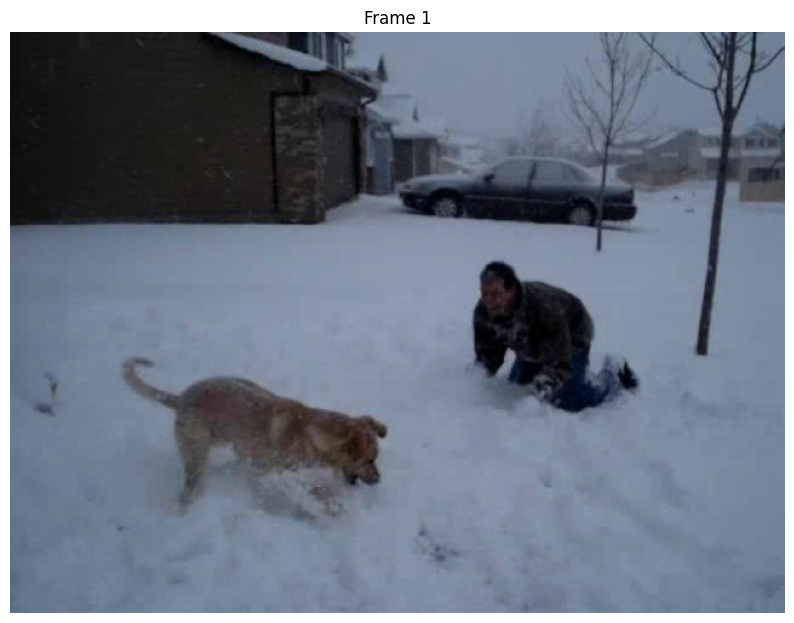

In [ ]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
# for idx, ax in enumerate(axes.flat):
#     ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
#     ax.set_title(f"Frame {idx + 1}")
#     ax.axis("off")

axes.imshow(np.squeeze(train_dataset[data_choice]), cmap="gray")
axes.set_title(f"Frame {1}")
axes.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

## Model Construction

To build a Convolutional LSTM model, we will use the
`ConvLSTM2D` layer, which will accept inputs of shape
`(batch_size, num_frames, width, height, channels)`, and return
a prediction movie of the same shape.

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
# x = layers.BatchNormalization()(x)
# x = layers.ConvLSTM2D(
#     filters=128,
#     kernel_size=(3, 3),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(3, 3),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)
x = layers.Conv3D(
    filters=3, kernel_size=(5, 5, 5), activation="relu", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

## Model Training

With our model and data constructed, we can now train the model.

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 2
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/2


1/1 [==============================] - ETA: 0s - loss: 3.8160

1/1 [==============================] - 5s 5s/step - loss: 3.8160 - val_loss: -1530.0984 - lr: 0.0010
Epoch 2/2
1/1 [==============================] - 2s 2s/step - loss: 1.2791 - val_loss: -1759.3778 - lr: 0.0010


In [ ]:
model.save('/content/drive/MyDrive/doubleConv.keras')

## Frame Prediction Visualizations

With our model now constructed and trained, we can generate
some example frame predictions based on a new video.

We'll pick a random example from the validation set and
then choose the first ten frames from them. From there, we can
allow the model to predict 10 new frames, which we can compare
to the ground truth frame predictions.

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/myModel1')

1/1 [==============================] - 0s 457ms/step
True


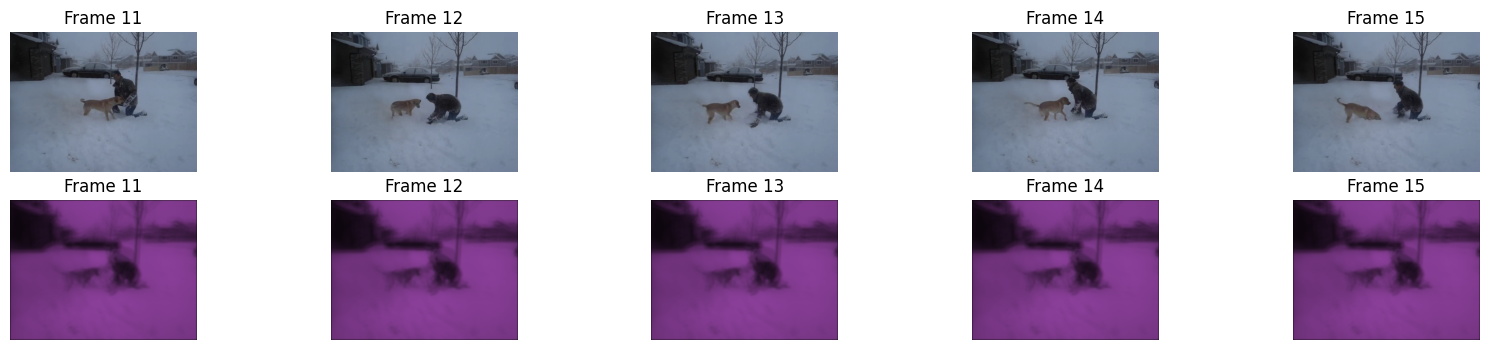

In [ ]:
# Select a random example from the validation dataset.
# example = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]
example = val_dataset[:5]

# Pick the first/last ten frames from the example.
frames = example
original_frames = example

# Predict a new set of 10 frames.
for i in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames[:5], axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 5, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    try:
      ax.imshow(original_frames[idx], cmap="gray")
      ax.set_title(f"Frame {idx + 11}")
      ax.axis("off")
    except:
      break

# Plot the new frames.
new_frames = frames[10:, ...]
print((new_frames[0]==new_frames[1]).all())
for idx, ax in enumerate(axes[1]):
    try:
      ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
      ax.set_title(f"Frame {idx + 11}")
      ax.axis("off")
    except:
      break

# Display the figure.
plt.show()

1/1 [==============================] - 1s 1s/step


False
0
1
2
3
4


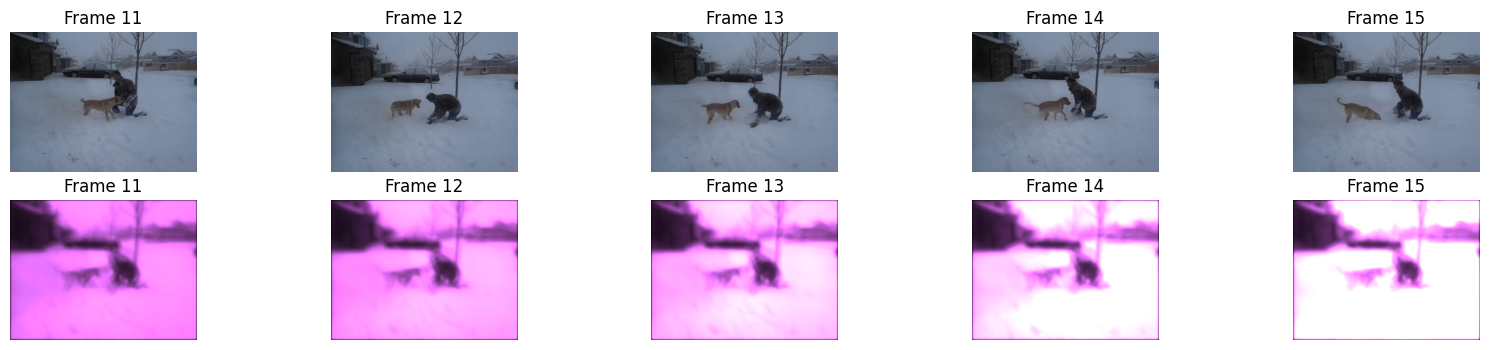

In [ ]:
# Select a random example from the validation dataset.
# example = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]
example = val_dataset

# Pick the first/last ten frames from the example.
frames = example
original_frames = example

# Predict a new set of 10 frames.
for i in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 5, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    try:
      ax.imshow(original_frames[idx], cmap="gray")
      ax.set_title(f"Frame {idx + 11}")
      ax.axis("off")
    except:
      break

# Plot the new frames.
new_frames = frames[10:, ...]
print((new_frames[0]==new_frames[1]).all())
for idx, ax in enumerate(axes[1]):
    try:
      ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
      print(idx)
      ax.set_title(f"Frame {idx + 11}")
      ax.axis("off")
    except:
      break

# Display the figure.
plt.show()

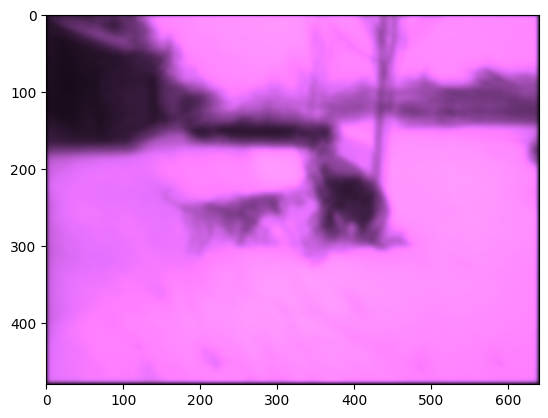

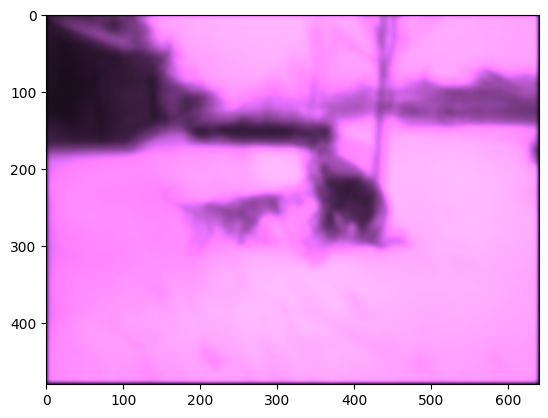

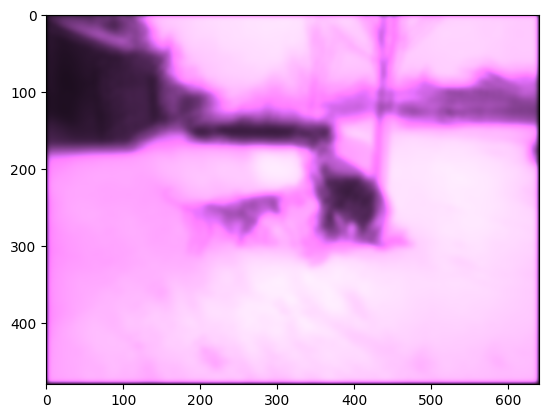

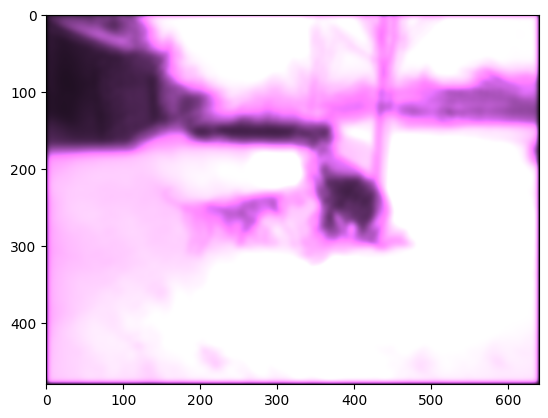

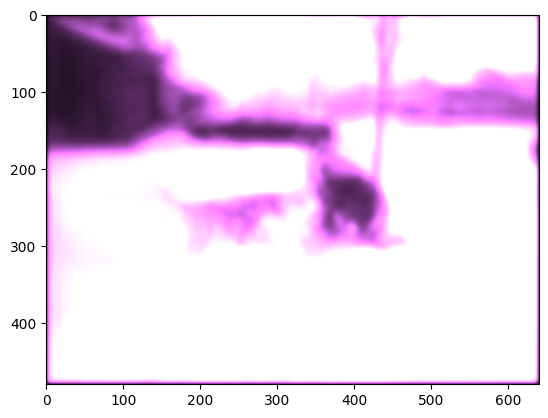

In [ ]:
for i in new_frames:
  plt.imshow(i)
  plt.show()

1/1 [==============================] - 1s 522ms/step


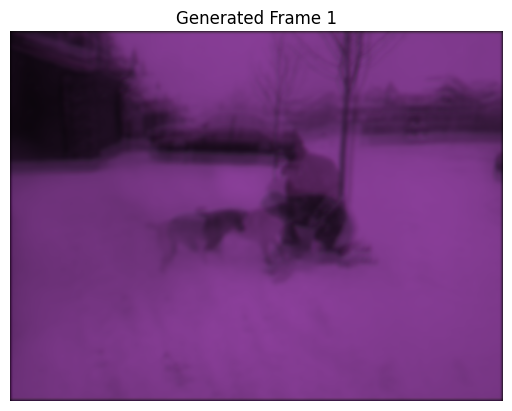

1/1 [==============================] - 0s 287ms/step


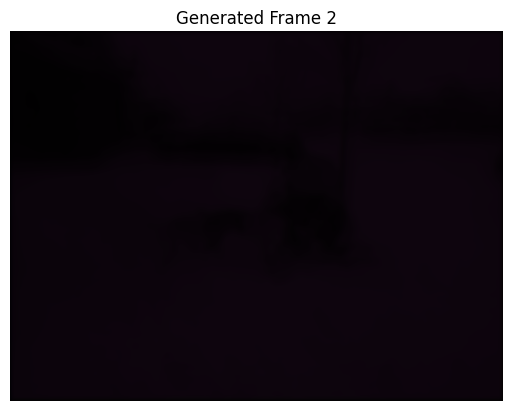

1/1 [==============================] - 0s 22ms/step


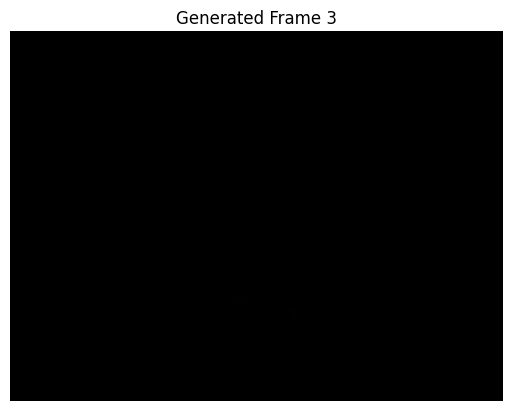

1/1 [==============================] - 0s 27ms/step


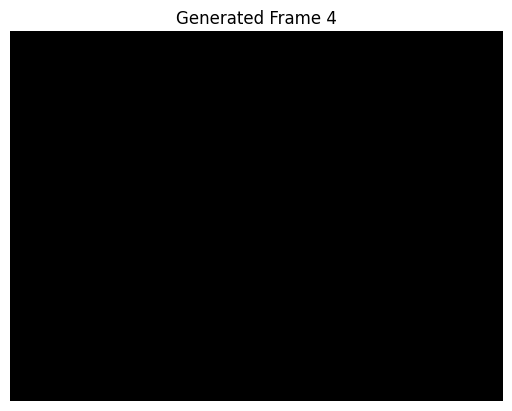

1/1 [==============================] - 0s 30ms/step


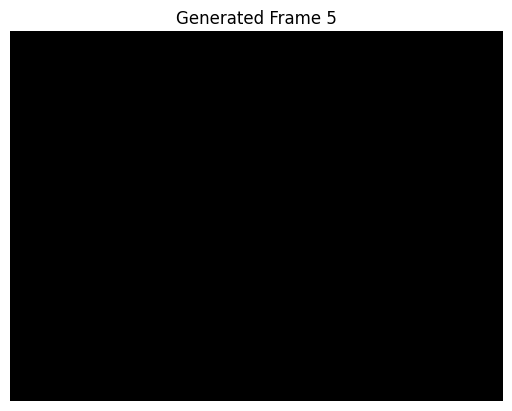

1/1 [==============================] - 0s 33ms/step


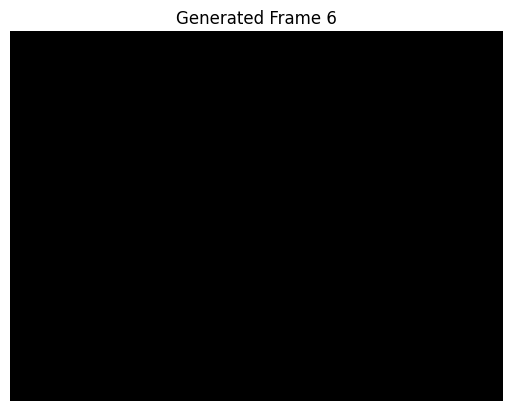

1/1 [==============================] - 0s 28ms/step


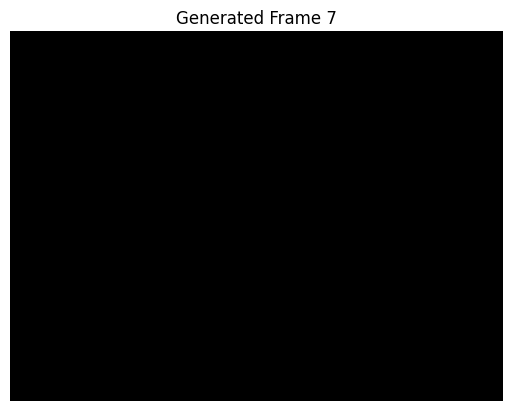

1/1 [==============================] - 0s 30ms/step


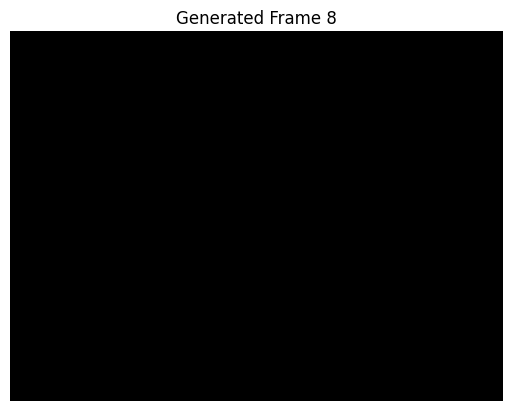

1/1 [==============================] - 0s 28ms/step


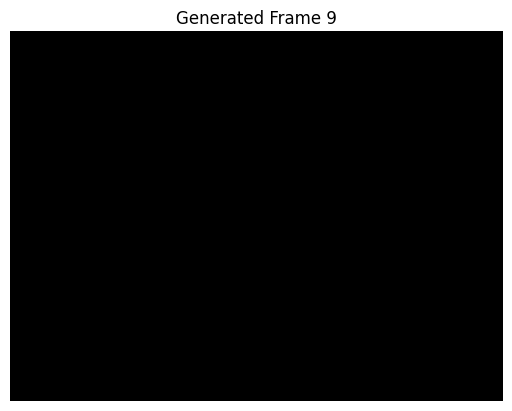

1/1 [==============================] - 0s 27ms/step


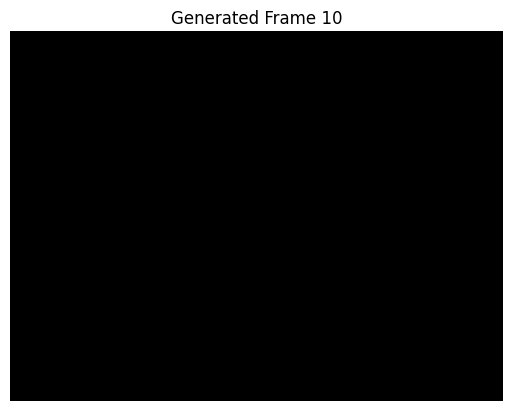

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming val_dataset is your validation dataset
# Ensure that you have the necessary imports for val_dataset and model

# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]
original_frames = example.copy()
frames = example.copy()

# Predict a new set of 10 frames.
for i in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)

    # Use only the last frame of the new prediction for the next iteration
    frames = new_prediction[-1:, ...]

    # Display the generated frame.
    plt.imshow(np.squeeze(frames), cmap="gray")
    plt.title(f"Generated Frame {i + 1}")
    plt.axis("off")
    plt.show()


In [ ]:
# # from PIL import Image
# # import numpy as np

# # # Assuming 'image_array' is your NumPy array representing the image
# # # Ensure it's in the correct format (RGB or grayscale) and data type (uint8)

# # # Convert NumPy array to PIL Image
# # image_pil = Image.fromarray(image_array)

# # # Save the PIL Image as JPEG
# # image_pil.save('saved_image.jpg')  # Save the image as 'saved_image.jpg' in the same directory

# # Construct a figure for the original and new frames.
# fig, axes = plt.subplots(2, 50, figsize=(20, 4))

# count = 1

# # Plot the original frames.
# for idx, ax in enumerate(axes[0]):
#     try:
#       ax.imshow(original_frames[idx], cmap="gray")
#       ax.set_title(f"Frame {idx + 11}")
#       ax.axis("off")
#       plt.savefig(f'saved_image_{idx}.jpg', bbox_inches='tight', pad_inches=0)
#       plt.clf()
#     except Exception as e:
#       print(e)
#       break

# # Plot the new frames.
# new_frames = frames[10:, ...]
# for idx, ax in enumerate(axes[1]):
#     try:
#       ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
#       # image_pil = Image.fromarray(original_frames[idx])
#       # image_pil.save(f'saved_image{count}.jpg')
#       # count += 1
#       ax.set_title(f"Frame {idx + 11}")
#       ax.axis("off")
#     except:
#       break

# # Display the figure.
# plt.show()

In [ ]:
# # import numpy as np

# # # Assuming you have frames stored as a list of NumPy arrays
# # # Replace this with your actual list of frames
# # # frames = [np.random.randint(0, 255, (100, 100, 3), dtype=np.uint8) for _ in range(10)]  # Example frames

# # # Save frames into a .npz file
# # np.savez('frames_data.npz', frames=example)

# # print("Frames saved into 'frames_data.npz'")

# print(example.shape)

In [ ]:
# import numpy as np
# import imageio

# # Assuming you have frames stored as a list of NumPy arrays
# # Replace this with your actual list of frames
# # frames = [np.random.randint(0, 255, (100, 100, 3), dtype=np.uint8) for _ in range(10)]  # Example frames

# # Define the filename for the output GIF
# output_filename = 'output.gif'

# # Save frames as a GIF using imageio
# imageio.mimsave(output_filename, original_frames, duration=0.5)  # Adjust duration as needed (in seconds)

# print(f"Frames saved as '{output_filename}'")


## Predicted Videos

Finally, we'll pick a few examples from the validation set
and construct some GIFs with them to see the model's
predicted videos.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/conv-lstm) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/conv-lstm).

In [ ]:
# # Select a random example from the validation dataset.
# example = val_dataset[np.random.choice(range(len(val_dataset)), size=10)]

# # Pick the first/last ten frames from the example.
# frames = example[:10, ...]
# original_frames = example[10:, ...]
# predicted_videos = []
# new_predictions = np.zeros(shape=(10, *frames[0].shape))
# print(new_predictions.shape)
# # Predict a new set of 10 frames.
# for i in range(10):
#     # Extract the model's prediction and post-process it.
#     frames = example[: 10 + i + 1, ...]
#     new_prediction = model.predict(np.expand_dims(frames, axis=0))
#     new_prediction = np.squeeze(new_prediction, axis=0)
#     predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

#     # Extend the set of prediction frames.
#     frames = np.concatenate((frames, predicted_frame), axis=0)

# # Create and save GIFs for each of the ground truth/prediction images.
# for frame_set in [original_frames, new_predictions]:
#     # Construct a GIF from the selected video frames.
#     current_frames = np.squeeze(frame_set)
#     current_frames = current_frames[..., np.newaxis] * np.ones(3)
#     current_frames = (current_frames * 255).astype(np.uint8)
#     list_of_frames = list(current_frames)
#     #print(current_frames)
# for current_frame in list_of_frames:  # Assuming you have a list of frames
# # Convert frames to uint8 (assuming the frames are in the range 0-255)
#   current_frames_uint8 = [np.uint8(frame) for frame in current_frame]

#   # Create GIF and append to predicted_videos
#   with io.BytesIO() as gif:
#       imageio.mimsave(gif, current_frames_uint8, "GIF", duration=200)
#       predicted_videos.append(gif.getvalue())

# # Display the videos.
# print(" Truth\tPrediction")
# for i in range(0, len(predicted_videos), 2):
#     # Construct and display an `HBox` with the ground truth and prediction.
#     box = HBox(
#         [
#             widgets.Image(value=predicted_videos[i], layout={'width': '400px', 'height': '300px'}),
#             widgets.Image(value=predicted_videos[i + 1], layout={'width': '400px', 'height': '300px'}),
#         ]
#     )
#     display(box)

In [ ]:
# import numpy as np
# import imageio
# import io
# from ipywidgets import HBox, widgets
# from IPython.display import display

# # Assuming you have defined your model and val_dataset before this point

# # Select a random example from the validation dataset.
# example = val_dataset[np.random.choice(range(len(val_dataset)), size=10)]

# # Pick the first/last ten frames from the example.
# frames = example[:10, ...]
# original_frames = example[10:, ...]
# predicted_videos = []
# new_predictions = np.zeros(shape=(10, *frames[0].shape))
# print(new_predictions.shape)

# # Predict a new set of 10 frames.
# for i in range(10):
#     # Extract the model's prediction and post-process it.
#     frames_input = frames[: 10 + i + 1, ...]
#     new_prediction = model.predict(np.expand_dims(frames_input, axis=0))
#     new_prediction = np.squeeze(new_prediction, axis=0)
#     predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

#     # Extend the set of prediction frames.
#     frames = np.concatenate((frames, predicted_frame), axis=0)
#     new_predictions[i, ...] = predicted_frame

# # Create and save GIFs for each of the ground truth/prediction images.
# for frame_set in [original_frames, new_predictions]:
#     # Construct a GIF from the selected video frames.
#     current_frames = np.squeeze(frame_set)
#     current_frames = (current_frames * 255).astype(np.uint8)
#     list_of_frames = list(current_frames)

#     # Create GIF and append to predicted_videos
#     with io.BytesIO() as gif:
#         # Reshape frames to (height, width, channels) before saving
#         imageio.mimsave(gif, [frame[:, :, 0] for frame in list_of_frames], "GIF", duration=200)
#         predicted_videos.append(gif.getvalue())

# # Display the videos.
# print(" Truth\tPrediction")
# for i in range(0, len(predicted_videos), 2):
#     # Construct and display an `HBox` with the ground truth and prediction.
#     box = HBox(
#         [
#             widgets.Image(value=predicted_videos[i]),
#             widgets.Image(value=predicted_videos[i + 1]),
#         ]
#     )
#     display(box)


In [ ]:
# import imageio
# import numpy as np
# import io

# # Select a random example from the validation dataset.
# example = val_dataset[np.random.choice(range(len(val_dataset)), size=2)]

# # Pick the first/last ten frames from the example.
# frames = example[:10, ...]
# original_frames = example[10:, ...]
# predicted_videos = []
# new_predictions = np.zeros(shape=(10, *frames[0].shape))

# # Predict a new set of 10 frames.
# for i in range(10):
#     # Extract the model's prediction and post-process it.
#     frames_to_predict = example[: 10 + i + 1, ...]
#     new_prediction = model.predict(np.expand_dims(frames_to_predict, axis=0))
#     new_prediction = np.squeeze(new_prediction, axis=0)
#     predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

#     # Update new_predictions with the predicted frame.
#     new_predictions[i] = predicted_frame

#     # Create GIF for the current frames and append to predicted_videos.
#     current_frames = np.concatenate((original_frames, new_predictions[:i + 1]), axis=0)
#     current_frames = (current_frames * 255).astype(np.uint8)

#     with io.BytesIO() as gif:
#         imageio.mimsave(gif, current_frames, "GIF", duration=0.5)
#         predicted_videos.append(gif.getvalue())

# # Display the videos.
# print("Truth\tPrediction")
# # Create GIFs after all iterations for visualization.
# final_predicted_video = []
# for i in range(0, len(predicted_videos), 2):
#     frames = [np.array(imageio.imread(frame)) for frame in [predicted_videos[i], predicted_videos[i + 1]]]

#     # Convert frames to np.uint8 format
#     frames = [(frame.astype(np.uint8)) for frame in frames]

#     # Concatenate frames and create GIF
#     gif_buffer = io.BytesIO()
#     imageio.mimsave(gif_buffer, frames, "GIF", duration=0.5)
#     final_predicted_video.append(gif_buffer.getvalue())

# # Display the videos.
# for gif_data in final_predicted_video:
#     display(widgets.Image(value=gif_data, format='gif', width='400px', height='300px'))

In [ ]:
import imageio
import numpy as np
import io
from IPython.display import display, Image
import ipywidgets as widgets

# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]
predicted_videos = []
new_predictions = np.zeros(shape=(10, *frames[0].shape))

# Predict a new set of 10 frames.
for i in range(10):
    # Extract the model's prediction and post-process it.
    frames_to_predict = example[:10 + i + 1, ...]
    new_prediction = model.predict(np.expand_dims(frames_to_predict, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Update new_predictions with the predicted frame.
    new_predictions[i] = predicted_frame

    # Create GIF for the current frames and append to predicted_videos.
    current_frames = np.concatenate((original_frames, new_predictions[:i + 1]), axis=0)
    current_frames = (current_frames * 255).astype(np.uint8)
    with io.BytesIO() as gif:
        imageio.mimsave(gif, current_frames, "GIF", duration=2000)
        predicted_videos.append(gif.getvalue())

# Display the videos.
final_predicted_video = []
for i in range(0, len(predicted_videos), 2):
    frames = [imageio.imread(io.BytesIO(frame)) for frame in predicted_videos[i:i + 2]]

    # Convert frames to np.uint8 format
    frames = [np.array(frame.astype(np.uint8)) for frame in frames]

    # Concatenate frames and create GIF
    gif_buffer = io.BytesIO()
    imageio.mimsave(gif_buffer, frames, "GIF", duration=2000)
    final_predicted_video.append(gif_buffer.getvalue())

# Display the videos.
for gif_data in final_predicted_video:
    display(widgets.Image(value=gif_data, format='gif', width='400px', height='300px'))


1/1 [==============================] - 0s 482ms/step


  frames = [imageio.imread(io.BytesIO(frame)) for frame in predicted_videos[i:i + 2]]



Image(value=b'GIF89a\x80\x02\xe0\x01\x87\x00\x00N\xba\x87N\xb9\x86N\xb8\x86M\xb8\x86M\xb8\x85M\xb8\x84M\xb7\x8…

Image(value=b'GIF89a\x80\x02\xe0\x01\x87\x00\x00N\xba\x87N\xb9\x86N\xb8\x86M\xb8\x86M\xb8\x85M\xb8\x84M\xb7\x8…

Image(value=b'GIF89a\x80\x02\xe0\x01\x87\x00\x00N\xba\x87N\xb9\x86N\xb8\x86M\xb8\x86M\xb8\x85M\xb8\x84M\xb7\x8…

Image(value=b'GIF89a\x80\x02\xe0\x01\x87\x00\x00N\xba\x87N\xb9\x86N\xb8\x86M\xb8\x86M\xb8\x85M\xb8\x84M\xb7\x8…

Image(value=b'GIF89a\x80\x02\xe0\x01\x87\x00\x00N\xba\x87N\xb9\x86N\xb8\x86M\xb8\x86M\xb8\x85M\xb8\x84M\xb7\x8…

In [ ]:
import imageio
import numpy as np
import io
from IPython.display import display, Image
import ipywidgets as widgets

# Define a function to convert a list of frames to a GIF
def create_gif(frames, filename, duration=2000):
    with imageio.get_writer(filename, mode='I', duration=duration) as writer:
        for frame in frames:
            writer.append_data(frame)

# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]
predicted_videos = []
new_predictions = np.zeros(shape=(10, *frames[0].shape))

# Predict a new set of 10 frames.
for i in range(10):
    # Extract the model's prediction and post-process it.
    frames_to_predict = example[:10 + i + 1, ...]
    new_prediction = model.predict(np.expand_dims(frames_to_predict, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Update new_predictions with the predicted frame.
    new_predictions[i] = predicted_frame

    # Create GIF for the current frames and append to predicted_videos.
    current_frames = np.concatenate((original_frames, new_predictions[:i + 1]), axis=0)
    current_frames = (current_frames * 255).astype(np.uint8)
    with io.BytesIO() as gif:
        imageio.mimsave(gif, current_frames, "GIF", duration=2000)  # Set duration to 5 seconds
        predicted_videos.append(gif.getvalue())

# Display the videos.
final_predicted_frames = []
for i in range(0, len(predicted_videos), 2):
    frames = [imageio.imread(io.BytesIO(frame)) for frame in predicted_videos[i:i + 2]]

    # Convert frames to np.uint8 format
    frames = [np.array(frame.astype(np.uint8)) for frame in frames]

    # Concatenate frames and create GIF
    gif_buffer = io.BytesIO()
    imageio.mimsave(gif_buffer, frames, "GIF", duration=2000)  # Set duration to 5 seconds
    gif_buffer.seek(0)  # Reset buffer position to start
    final_predicted_frames.append(gif_buffer.getvalue())  # Append the GIF content

# Create and save the final video
final_video_frames = [imageio.imread(io.BytesIO(frame)) for frame in final_predicted_frames]
final_video_filename = 'final_predicted_video.gif'
create_gif(final_video_frames, final_video_filename, duration=2000)  # Set duration to 5 seconds

# Display the final video
display(widgets.Image(value=open(final_video_filename, 'rb').read(), format='gif', width='400px', height='300px'))


1/1 [==============================] - 0s 458ms/step


  frames = [imageio.imread(io.BytesIO(frame)) for frame in predicted_videos[i:i + 2]]

  final_video_frames = [imageio.imread(io.BytesIO(frame)) for frame in final_predicted_frames]



Image(value=b'GIF89a\x80\x02\xe0\x01\x87\x00\x00\x97x\x90\x97w\x90\x96w\x8f\x95w\x8f\x96v\x8f\x95v\x8f\x95v\x8…

In [ ]:
import moviepy.editor as mp

clip = mp.VideoFileClip("final_predicted_video.gif")
clip.write_videofile("final_predicted_video.mp4")

Moviepy - Building video final_predicted_video.mp4.
Moviepy - Writing video final_predicted_video.mp4



Moviepy - Done !
Moviepy - video ready final_predicted_video.mp4


In [ ]:
# import imageio
# import numpy as np
# import io
# from IPython.display import display, Video
# import ipywidgets as widgets

# # Define a function to convert a list of frames to a video
# def create_video(frames, filename, fps=10):
#     with imageio.get_writer(filename, fps=fps) as writer:
#         for frame in frames:
#             writer.append_data(frame)

# # Select a random example from the validation dataset.
# example = val_dataset[np.random.choice(range(len(val_dataset)), size=2)]

# # Pick the first/last ten frames from the example.
# frames = example[:10, ...]
# original_frames = example[10:, ...]
# predicted_videos = []
# new_predictions = np.zeros(shape=(10, *frames[0].shape))

# # Predict a new set of 10 frames.
# for i in range(10):
#     # Extract the model's prediction and post-process it.
#     frames_to_predict = example[:10 + i + 1, ...]
#     new_prediction = model.predict(np.expand_dims(frames_to_predict, axis=0))
#     new_prediction = np.squeeze(new_prediction, axis=0)
#     predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

#     # Update new_predictions with the predicted frame.
#     new_predictions[i] = predicted_frame

#     # Create GIF for the current frames and append to predicted_videos.
#     current_frames = np.concatenate((original_frames, new_predictions[:i + 1]), axis=0)
#     current_frames = (current_frames * 255).astype(np.uint8)
#     with io.BytesIO() as gif:
#         imageio.mimsave(gif, current_frames, "GIF", duration=200)
#         predicted_videos.append(gif.getvalue())

# # Display the videos.
# final_video_frames = []
# for i in range(0, len(predicted_videos), 2):
#     frames = [imageio.imread(io.BytesIO(frame)) for frame in predicted_videos[i:i + 2]]

#     # Convert frames to np.uint8 format
#     frames = [np.array(frame.astype(np.uint8)) for frame in frames]

#     # Concatenate frames and create video
#     video_buffer = io.BytesIO()
#     create_video(frames, video_buffer)
#     video_buffer.seek(0)  # Reset buffer position to start
#     final_video_frames.append(video_buffer.getvalue())  # Append the video content

# # Create and save the final video
# final_video_filename = 'final_predicted_video.mp4'  # Change this to your desired video file name with .mp4 extension
# create_video(final_video_frames, final_video_filename)

# # Display the final video
# display(Video(final_video_filename, width=400, height=300))


In [ ]:
# import imageio
# import numpy as np
# import io
# import os
# from IPython.display import display
# import ipywidgets as widgets

# # Select a random example from the validation dataset.
# example = val_dataset[np.random.choice(range(len(val_dataset)), size = 2)]

# # Pick the first/last ten frames from the example.
# frames = example[:10, ...]
# original_frames = example[10:, ...]
# predicted_videos = []
# new_predictions = np.zeros(shape=(10, *frames[0].shape))

# # Predict a new set of 10 frames.
# for i in range(10):
#     # Extract the model's prediction and post-process it.
#     frames_to_predict = example[: 10 + i + 1, ...]
#     new_prediction = model.predict(np.expand_dims(frames_to_predict, axis=0))
#     new_prediction = np.squeeze(new_prediction, axis=0)
#     predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

#     # Create GIF for the current frames and append to predicted_videos.
#     current_frames = np.concatenate((original_frames, new_predictions[:i + 1]), axis=0)
#     current_frames = (current_frames * 255).astype(np.uint8)

#     with io.BytesIO() as gif:
#         imageio.mimsave(gif, current_frames, "GIF", duration=200)
#         predicted_videos.append(gif.getvalue())

# # Display the videos and save as an output video file.
# final_predicted_video = []
# for i in range(0, len(predicted_videos), 2):
#     frames = [np.array(imageio.imread(frame)) for frame in [predicted_videos[i], predicted_videos[i + 1]]]

#     # Ensure frames are properly formatted
#     frames = [(frame.astype(np.uint8)) for frame in frames]

#     # Create GIF from frames
#     gif_buffer = io.BytesIO()
#     imageio.mimsave(gif_buffer, frames, "GIF", duration=200)
#     final_predicted_video.append(gif_buffer.getvalue())

# # Display the generated GIFs using widgets
# for gif_data in final_predicted_video:
#     display(widgets.Image(value=gif_data, format='gif', width='400px', height='300px'))


# # Save the generated GIFs as a video file
# output_file_path = 'output_video.mp4'  # Change this to your desired output file path

# # Collect frames from generated GIFs
# frames_for_video = []
# for gif_data in final_predicted_video:
#     gif_bytes = io.BytesIO(gif_data)
#     gif_bytes.seek(0)
#     gif_images = imageio.mimread(gif_bytes)
#     frames_for_video.extend(gif_images)

# # Write frames to the output video file
# with imageio.get_writer(output_file_path, fps=10) as writer:
#     for frame in frames_for_video:
#         writer.append_data(frame)

# print(f"Video saved at: {os.path.abspath(output_file_path)}")
